In [1]:
import numpy as np
import scipy as sp

import autograd

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
#sys.path.insert(0, './../src/vb_modeling/')
sys.path.insert(0, './../')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
from shift_only_lib import LinearSensitivity
import common_modeling_lib 
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)



/home/runjing_liu/Documents/BNP/autograd/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


ModuleNotFoundError: No module named 'LinearResponseVariationalBayes.OptimizationUtils'

# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [11]:
from matplotlib.patches import Ellipse
import matplotlib.cm as cm


import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [13]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [14]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [15]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

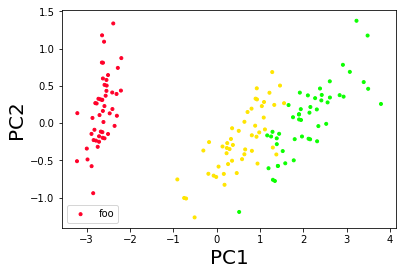

In [23]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
plt.xlabel('PC1', fontsize = 20)
plt.ylabel('PC2', fontsize = 20)

In [9]:
# experiment with plotting ellipses
# this will be useful later when we learn the 
# covariances for each cluster

centroids = np.zeros((dim, 3))
cov = np.zeros((3, dim, dim))
for k in range(3): 
    # get data from this feature
    iris_features_k = iris_features[iris_species == k, :]
    
    # get centroid
    centroids[:, k] = np.mean(iris_features_k, axis = 0)
    
    # get covariance
    cov[k, :, :] = np.cov(iris_features_k.T)


In [10]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

In [11]:
centroids_pc, cov_pc = transform_params_to_pc_space(pca_fit, centroids, cov)

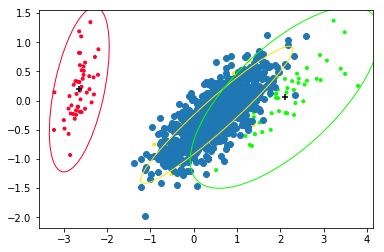

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig, \
              centroids_pc, cov_pc)

k = 1
samples = np.random.multivariate_normal(centroids[:, k], cov[k], size = 1000)
# samples_pc = pca_fit.transform(samples)
samples_pc = np.random.multivariate_normal(centroids_pc[:, k], cov_pc[k], size = 1000)
fig.scatter(samples_pc[:, 0], samples_pc[:, 1])

# Set prior params

In [13]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim))

In [14]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


# Set up model

In [15]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [16]:
set_truth = False

In [17]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [18]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

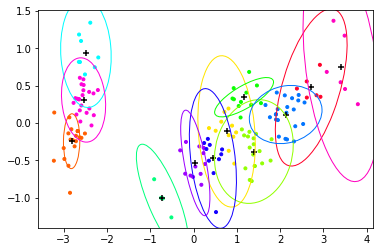

In [19]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [20]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


In [21]:
# %%R -i init_clusters -i init_centroids -w 4 -h 3 --units in -r 200
#     k_approx <- dim(init_centroids)[2]
#     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
#     pca_centroids_init$cluster <- as.factor(seq(1, k_approx, by = 1))
#     # TODO: plot the centroids too 

#     # add our initial clusterings to the dataframe
#     df_pca$init_clusters <- as.factor(init_clusters)
    
#     # plot
#     ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = init_clusters), size = 0.5) + 
#         theme(legend.position="none") 

# Optimize!

In [22]:
t0 = time.time()
best_param, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model.optimize_full(init_global_free_param,
    init_max_iter=100,
    final_max_iter=500)
t_newton = time.time() - t0

print('done. ')

Iter: 0	 RMSE: 5.4171664084976205	 Objective: 7847.62430637586
Iter: 10	 RMSE: 12.979178597164944	 Objective: 4936.7687434297795
Iter: 20	 RMSE: 13.04905122507649	 Objective: 2374.67017203691
Iter: 30	 RMSE: 28.801949578319242	 Objective: 741.3398291330069
Iter: 40	 RMSE: 14.636955669100661	 Objective: 126.19445254571819
Iter: 50	 RMSE: 12.763388852880636	 Objective: -140.48472943939885
Iter: 60	 RMSE: 12.45324357914632	 Objective: -204.72820775301116
Iter: 70	 RMSE: 12.42569932176502	 Objective: -222.48551080706517
Iter: 80	 RMSE: 12.404717387036083	 Objective: -231.0063626628884
Iter: 90	 RMSE: 12.39843186863714	 Objective: -236.17197317291948
Iter: 100	 RMSE: 12.40428188631273	 Objective: -238.98086885280048
         Current function value: -240.085097
         Iterations: 100
         Function evaluations: 108
         Gradient evaluations: 108
Iter: 110	 RMSE: 12.373329947374362	 Objective: -242.21751781307378
Iter: 120	 RMSE: 12.423277697827487	 Objective: -244.16640721868353
Opt

In [23]:
newton_results = deepcopy(model)

In [24]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [25]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [26]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

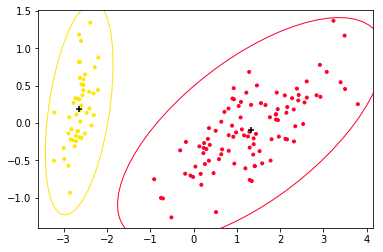

In [27]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

In [28]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

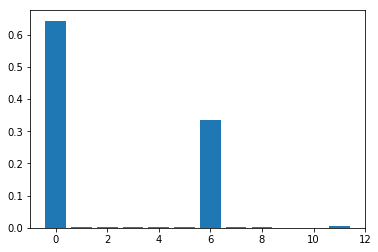

In [29]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

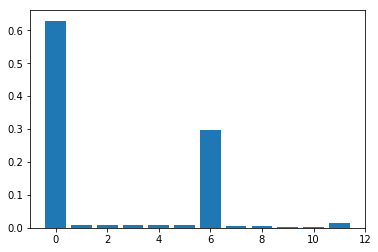

In [30]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   7., 138.]),
 array([0.40635326, 0.46571794, 0.52508261, 0.58444728, 0.64381196,
        0.70317663, 0.76254131, 0.82190598, 0.88127065, 0.94063533,
        1.        ]),
 <a list of 10 Patch objects>)

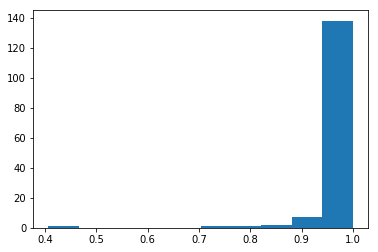

In [31]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Lets look at a few random restarts, see how results chage

In [32]:
n_restarts = 6
init_global_free_param_array = []
global_free_param_array = []

for i in tqdm(range(n_restarts)):
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
    best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=100,
            final_max_iter=500, disp=True)
    
    init_global_free_param_array.append(init_global_free_param)
    global_free_param_array.append(best_param)



  0%|          | 0/6 [00:00<?, ?it/s]

Iter: 0	 RMSE: 5.598913912817113	 Objective: 17300.830989444275
Iter: 10	 RMSE: 8.186647050577383	 Objective: 9353.025971792838
Iter: 20	 RMSE: 17.604439197566663	 Objective: 3679.1778198799057
Iter: 30	 RMSE: 28.844967248748663	 Objective: 1285.4023953046515
Iter: 40	 RMSE: 24.87022856537845	 Objective: 784.8569037953555
Iter: 50	 RMSE: 12.568455715211892	 Objective: 263.0688300753758
Iter: 60	 RMSE: 12.45978910062144	 Objective: -43.797993794550706
Iter: 70	 RMSE: 12.467084206502491	 Objective: -173.77893822292762
Iter: 80	 RMSE: 12.452246968079251	 Objective: -197.83578905319922
Iter: 90	 RMSE: 12.445599555993342	 Objective: -214.91509651278886
Iter: 100	 RMSE: 12.446437287730388	 Objective: -223.05279803772405
         Current function value: -227.352693
         Iterations: 100
         Function evaluations: 107
         Gradient evaluations: 107
Iter: 110	 RMSE: 12.40226975358725	 Objective: -237.21090161054946
Iter: 120	 RMSE: 12.423230135817436	 Objective: -242.50585078311238
O

 17%|█▋        | 1/6 [00:19<01:35, 19.07s/it]

         Current function value: -242.513382
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.034747575446974e-14, f_diff = 1.4210854715202004e-13
Iter: 0	 RMSE: 5.501912308288866	 Objective: 17718.00583927992
Iter: 10	 RMSE: 10.849395573143102	 Objective: 9310.273003879245
Iter: 20	 RMSE: 11.477629530088887	 Objective: 3274.0448725466194
Iter: 30	 RMSE: 12.626767370890912	 Objective: 1112.4043600879031
Iter: 40	 RMSE: 12.866573850455385	 Objective: 624.6701280040344
Iter: 50	 RMSE: 12.468330280422752	 Objective: 300.67406196095305
Iter: 60	 RMSE: 12.508398532050109	 Objective: 52.797623045403725
Iter: 70	 RMSE: 12.456609312602046	 Objective: -140.61079551777897
Iter: 80	 RMSE: 12.453673426605565	 Objective: -200.47187051305946
Iter: 90	 RMSE: 12.46166991722395	 Objective: -225.23943287078228
Iter: 100	 RMSE: 12.432384135171645	 Objective: -232.99270062466502
         Current function value: -233

 33%|███▎      | 2/6 [00:37<01:15, 18.99s/it]

         Current function value: -242.691060
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 4.4146381428938897e-14, f_diff = 1.7053025658242404e-13
Iter: 0	 RMSE: 6.292717731907797	 Objective: 17596.837111923975
Iter: 10	 RMSE: 9.37524840874841	 Objective: 9534.251841991872
Iter: 20	 RMSE: 19.03690668601968	 Objective: 6174.149290282599
Iter: 30	 RMSE: 13.177978001845707	 Objective: 2378.9667901450193
Iter: 40	 RMSE: 16.36865831563713	 Objective: 1217.519800451287
Iter: 50	 RMSE: 12.900783163195207	 Objective: 810.1042342449136
Iter: 60	 RMSE: 12.590867764352355	 Objective: 306.364922479843
Iter: 70	 RMSE: 12.468185617101994	 Objective: -20.23849508391976
Iter: 80	 RMSE: 12.445673393088272	 Objective: -153.38325860325995
Iter: 90	 RMSE: 12.446630122256089	 Objective: -186.885877811859
Iter: 100	 RMSE: 12.446032207075184	 Objective: -212.79701701436977
Iter: 110	 RMSE: 11.87401968552469	 Objective

 50%|█████     | 3/6 [01:01<01:01, 20.36s/it]

         Current function value: -244.476456
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 6.83932077638616e-14, f_diff = 4.831690603168681e-13
Iter: 0	 RMSE: 5.969175400059551	 Objective: 7636.023813918115
Iter: 10	 RMSE: 10.598110900330646	 Objective: 4476.2556207608195
Iter: 20	 RMSE: 22.95785384401806	 Objective: 983.5797114623999
Iter: 30	 RMSE: 14.07011878643709	 Objective: 123.72672347495924
Iter: 40	 RMSE: 11.51471781231256	 Objective: -102.85986442939034
Iter: 50	 RMSE: 12.114202169152696	 Objective: -194.86862634152007
Iter: 60	 RMSE: 12.430371807154678	 Objective: -218.09677217599997
Iter: 70	 RMSE: 12.441795574375178	 Objective: -228.7843241875703
Iter: 80	 RMSE: 12.414824248561116	 Objective: -233.34669237451848
Iter: 90	 RMSE: 12.403392560471989	 Objective: -236.75675485892927
Iter: 100	 RMSE: 12.399616734374808	 Objective: -238.78133136657794
         Current function value: -239.

 67%|██████▋   | 4/6 [01:17<00:38, 19.29s/it]

         Current function value: -243.517255
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 4.202389304597265e-14, f_diff = 3.410605131648481e-13
Iter: 0	 RMSE: 6.677848926271651	 Objective: 7765.843429375735
Iter: 10	 RMSE: 8.019993099141992	 Objective: 4664.469793001335
Iter: 20	 RMSE: 36.9354531601236	 Objective: 2014.985278409945
Iter: 30	 RMSE: 29.865623812440113	 Objective: 229.2709068337397
Iter: 40	 RMSE: 25.006384856128435	 Objective: -45.35620070599384
Iter: 50	 RMSE: 20.914854687337556	 Objective: -94.10777439647487
Iter: 60	 RMSE: 18.880909312284682	 Objective: -116.65664003689706
Iter: 70	 RMSE: 13.677414806727503	 Objective: -132.84307292925425
Iter: 80	 RMSE: 12.466772718190457	 Objective: -163.3185532379435
Iter: 90	 RMSE: 12.454732603112065	 Objective: -191.62838180052972
Iter: 100	 RMSE: 12.42509347738048	 Objective: -212.62618896215753
         Current function value: -217.6807

 83%|████████▎ | 5/6 [02:02<00:24, 24.58s/it]

Iter: 160	 RMSE: 11.319932464243687	 Objective: -237.45610887481263
         Current function value: -237.456109
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 5.4250874625960677e-14, f_diff = 5.115907697472721e-13
Iter: 0	 RMSE: 5.509730988580523	 Objective: 17322.973005394113
Iter: 10	 RMSE: 9.730619827081247	 Objective: 9246.658432683003
Iter: 20	 RMSE: 45.28298209603404	 Objective: 4262.8962724110415
Iter: 30	 RMSE: 39.04585284449401	 Objective: 1967.9819424996335
Iter: 40	 RMSE: 49.363047872971094	 Objective: 872.1264353765249
Iter: 50	 RMSE: 70.45952006003543	 Objective: 368.8652661206107
Iter: 60	 RMSE: 65.65382857661146	 Objective: 144.11720885233626
Iter: 70	 RMSE: 34.43996561304397	 Objective: -40.49703130999234
Iter: 80	 RMSE: 12.535845666053815	 Objective: -169.07294462680096
Iter: 90	 RMSE: 12.535542872460226	 Objective: -206.29879868600133
Iter: 100	 RMSE: 12.451060444659875	 Object

100%|██████████| 6/6 [02:20<00:00, 23.37s/it]

         Current function value: -252.312218
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 2: x_diff = 4.105530409452378e-14, f_diff = 8.810729923425242e-13


In [33]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [34]:
# get cluster assignments
cluster_assignments_array = []
bnp_centroids_pc_array = []
bnp_cluster_covs_pc_array = []

for i in range(n_restarts): 
    model.set_from_global_free_par(global_free_param_array[i])
    bnp_centroids_pc_, bnp_cluster_covs_pc_ = \
        transform_params_to_pc_space(pca_fit, \
                                     model.vb_params['global']['centroids'].get(),\
                                     np.linalg.inv(model.vb_params['global']['gamma'].get()))
        
    bnp_centroids_pc_array.append(bnp_centroids_pc_)
    bnp_cluster_covs_pc_array.append(bnp_cluster_covs_pc_)
    
    cluster_assignments_array.append(np.argmax(model.vb_params['e_z'].get(), axis = 1))
    
    print('final objective val, restart {}: '.format(i), model.set_z_get_kl())

final objective val, restart 0:  -242.5133824504718
final objective val, restart 1:  -242.69105972952434
final objective val, restart 2:  -244.4764555927296
final objective val, restart 3:  -243.51725518900088
final objective val, restart 4:  -237.45610887481308
final objective val, restart 5:  -252.31221774289583


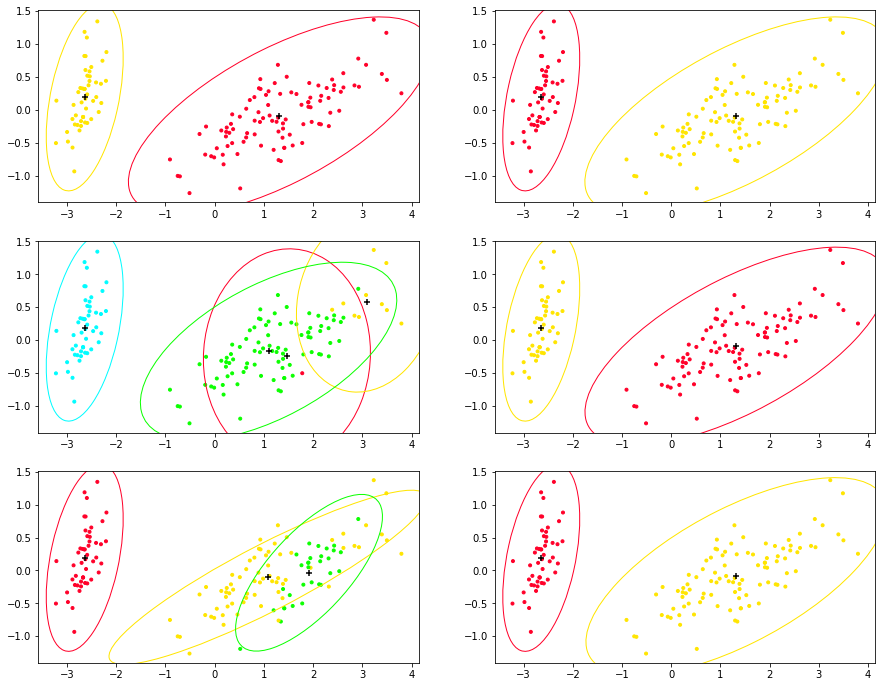

In [35]:
f, axarr = plt.subplots(3, 2, figsize = (15, 12))

for i in range(n_restarts): 
    axarr_indx1 = int(np.floor(i / 2))
    axarr_indx2 = i % 2
    plot_clusters(pc_features[:, 0], pc_features[:, 1], cluster_assignments_array[i], \
                  colors1, axarr[axarr_indx1, axarr_indx2], 
                 centroids = bnp_centroids_pc_array[i][:, np.unique(cluster_assignments_array[i])], \
                 cov = bnp_cluster_covs_pc_array[i][np.unique(cluster_assignments_array[i])])

In [36]:
# %%R
# # an R multiplot function
# multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
#   library(grid)

#   # Make a list from the ... arguments and plotlist
#   plots <- c(list(...), plotlist)

#   numPlots = length(plots)

#   # If layout is NULL, then use 'cols' to determine layout
#   if (is.null(layout)) {
#     # Make the panel
#     # ncol: Number of columns of plots
#     # nrow: Number of rows needed, calculated from # of cols
#     layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
#                     ncol = cols, nrow = ceiling(numPlots/cols))
#   }

#  if (numPlots==1) {
#     print(plots[[1]])

#   } else {
#     # Set up the page
#     grid.newpage()
#     pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

#     # Make each plot, in the correct location
#     for (i in 1:numPlots) {
#       # Get the i,j matrix positions of the regions that contain this subplot
#       matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

#       print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
#                                       layout.pos.col = matchidx$col))
#     }
#   }
# }


In [37]:
# %%R -i cluster_assignments_array -i n_restarts -w 5 -h 8 --units in -r 200
# # pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# # pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# plot_list <- list()
# for(i in 1:n_restarts){
#     # add our bnp clusterings to the dataframe
#     # print(cluster_assignments_array[, i])
#     df_pca$bnp_clusters <- as.factor(cluster_assignments_array[, i])
    
#     plot <- ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#      theme(legend.position="none") 
    
#     plot_list[[i]] <- plot
# }

# # plot_list[[1]]

# multiplot(plotlist = plot_list, cols = 2)

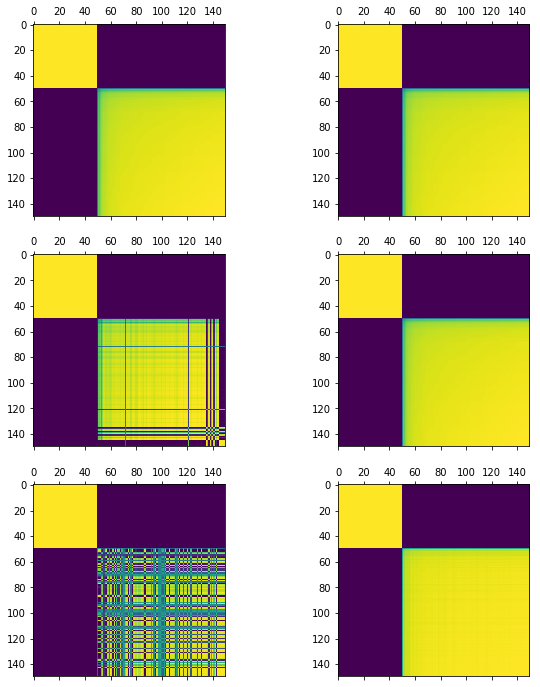

In [38]:
f, axarr = plt.subplots(3, 2, figsize=(10, 12))

for i in range(n_restarts): 
    model.set_from_global_free_par(global_free_param_array[i])
    e_z = model.vb_params['e_z'].get()
    co_cluster_mat = np.dot(e_z, e_z.T)
    
    if i == 0: 
        dis = (co_cluster_mat + 1) ** (-1)
        dis[np.diag_indices_from(dis)] = 0
        dis = spatial.distance.squareform(dis, checks=False)
        y = sch.linkage(dis, method='average')
        indx = sch.dendrogram(y, no_plot=True)["leaves"]
    
    co_cluster_mat = co_cluster_mat[indx][:, indx]
    
    fig_indx1 = int(np.floor(i / 2))
    fig_indx2 = int(i % 2)
    axarr[fig_indx1, fig_indx2].matshow(co_cluster_mat)
    

# Parametric sensitivity

In [39]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = LinearSensitivity(model, moment_model)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)


In [ ]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))


In [ ]:
# sensitivity to data
plt.plot(linear_sens.data_sens_mat.T, '.');


In [ ]:
# Choose a prior parameter and check the sensitivity
print('prior indices')
print(model.prior_indices)

prior_ind = 0 # this is the alpha, the parameter for the dp prior

epsilon = 0.5


In [ ]:
model_perturbed = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks)

perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
perturb_vec[prior_ind] = epsilon

model_perturbed.prior_params.set_vector(
    model_perturbed.prior_params.get_vector() + perturb_vec)

pert_opt_free_param = \
    model_perturbed.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


In [ ]:
free_perturb_vec = model_perturbed.prior_params.get_free() - model.prior_params.get_free()
lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

diff_vec = pert_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')
plt.title('global free parameters')


In [ ]:
## check e_z sensitivity

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
cluster_weights_orig = np.mean(e_z_orig, axis = 0)

linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
cluster_weights_pert = np.mean(e_z_pert, axis = 0)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
cluster_weights_lr = np.mean(e_z_lr, axis = 0)

diff_vec = (e_z_pert - e_z_orig).flatten()
lr_diff_vec = (e_z_lr - e_z_orig).flatten()

plt.title('E_z sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
# check sensitivity of cluster weights

diff_vec = (np.sort(cluster_weights_pert) - np.sort(cluster_weights_orig)).flatten()
lr_diff_vec = (np.sort(cluster_weights_lr) - np.sort(cluster_weights_orig)).flatten()

plt.title('cluster weight sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
# check co-clustering sensitivity
coclustering_orig = np.matmul(e_z_orig, e_z_orig.T)
coclustering_pert = np.matmul(e_z_pert, e_z_pert.T)
coclustering_lr = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (coclustering_pert - coclustering_orig).flatten()
lr_diff_vec = (coclustering_lr - coclustering_orig).flatten()


plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_beta_lr = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec = (e_beta_pert - e_beta_orig).flatten()
lr_diff_vec = (e_beta_lr - e_beta_orig).flatten()

plt.title('Centroids sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
def get_mixture_weights_array(stick_lengths):
    # computes mixture weights from an array of stick lengths
    k_approx = np.shape(stick_lengths)[1]
    n_sticks = np.shape(stick_lengths)[0]
    
    stick_lengths_1m = 1 - stick_lengths
    stick_remain = np.hstack((np.ones((n_sticks, 1)),
                                np.cumprod(stick_lengths_1m, axis = 1)))
    stick_add = np.hstack((stick_lengths, 
                                np.ones((n_sticks, 1))))

    return stick_remain * stick_add


In [ ]:
def get_e_number_clusters_from_logit_sticks(vb_params, threshold, samples = 100000): 
    
    # get logitnormal params
    mu = vb_params['global']['v_sticks']['mean'].get()
    sigma = vb_params['global']['v_sticks']['info'].get()
    k_approx = len(mu)
    
    # sample from univariate normal
    unv_norm_samples = np.random.normal(0, 1, size = (samples, k_approx))
    
    # sample sticks from variational distribution
    stick_samples = sp.special.expit(unv_norm_samples / np.sqrt(sigma) + mu)
    
    # get posterior weights
    weight_samples = get_mixture_weights_array(stick_samples)
    # number of observations in the dataset
    n_obs = vb_params['e_z'].shape()[0]
    
#     print(np.mean(weight_samples, axis = 0))
#     print(np.mean(vb_params['e_z'].get(), axis = 0))
    
    return np.mean(np.sum(1 - (1 - weight_samples)**n_obs, axis = 1))
    
#     # get fraction above threshold
#     # and sum to get expected number of clusters
#     return np.sum(np.mean(weight_samples > threshold, axis = 0))

In [ ]:
def get_e_number_clusters_from_free_par(model, global_free_params, threshold, samples = 100000): 
    model.global_vb_params.set_free(global_free_params)
    return get_e_number_clusters_from_logit_sticks(model.vb_params, threshold, samples)

In [ ]:
get_e_number_clusters_from_logit_sticks(newton_results.vb_params, threshold=1/k_approx)

In [ ]:
get_e_number_clusters_from_free_par(model, newton_results.global_vb_params.get_free(), threshold = 1 / k_approx)

# check how well the linear approximation holds over a range of epsilons

In [ ]:
epsilons = [-3, -2, -1.5, -1, -0.5, 0.5, 1, 2, 4, 6]
pert_opt_free_param_list = []
pert_prior_free_params_list = []

# re-optimize for each epsilon
for i in range(len(epsilons)): 
    print('optimizing when epsilon = {}'.format(epsilons[i]))
    
    perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
    perturb_vec[prior_ind] = epsilons[i]

    model_perturbed.prior_params.set_vector(
        newton_results.prior_params.get_vector() + perturb_vec)
    # print(model_perturbed.prior_params.get_vector())
    
    pert_prior_free_params_list.append(model_perturbed.prior_params.get_free())
    
    pert_opt_free_param_list.append(
        model_perturbed.optimize_full(best_param, init_max_iter=100, final_max_iter=500, disp = False)[0])


In [ ]:
# check global params

linear_sens.moment_model.set_moments_from_free_par(best_param)


f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Global params sensitivity')

for i in range(len(epsilons)): 
    
    # diff in prior free params
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    
    # get linear response global free params
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)
    
    # diff in original global free params
    diff_vec = (pert_opt_free_param_list[i] - best_param).flatten()
    lr_diff_vec = (lr_free_param_diff_vec).flatten()
    
    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+')
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    
f.tight_layout()
blah.set_y(1.01)

# f.savefig('../writing/Bryan_writing/parametric_sens_figures/beta_sens_range.png', bbox_inches='tight')


In [ ]:
# check e_z's 

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_og = np.matmul(e_z_orig, e_z_orig.T)

f, axarr = plt.subplots(5, 2, figsize=(10, 15))
blah = f.suptitle('Co-clustering sensitivity')

for i in range(len(epsilons)): 
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)

    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
    co_cluster_pert = np.matmul(e_z_pert, e_z_pert.T)
    
    linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
    e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
    co_cluster_lr = np.matmul(e_z_lr, e_z_lr.T)
    
#     diff_vec = (e_z_pert - e_z_orig).flatten()
#     lr_diff_vec = (e_z_lr - e_z_orig).flatten()

    diff_vec = (co_cluster_pert - co_cluster_og).flatten()
    lr_diff_vec = (co_cluster_lr - co_cluster_og).flatten()

    indx1 = int(np.floor(i / 2))
    indx2 = i % 2
    axarr[indx1, indx2].plot(diff_vec, lr_diff_vec, 'r+', alpha = 0.1)
    axarr[indx1, indx2].plot(diff_vec, diff_vec, 'k')    
    axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))
    axarr[indx1, indx2].set_xlabel('true diff')
    axarr[indx1, indx2].set_ylabel('lr diff')
    # axarr[indx1, indx2].set_xlim([-0.06, 0.06])
    
f.tight_layout()
blah.set_y(1.01)


In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_beta_orig = linear_sens.moment_model.moment_params['centroids'].get()

e_n_clusters = np.zeros(len(epsilons))
e_n_clusters_lr = np.zeros(len(epsilons))
for i in range(len(epsilons)): 
    e_n_clusters[i] = get_e_number_clusters_from_free_par(model, pert_opt_free_param_list[i], \
                                                        threshold = 0.5 / k_approx)
    
    free_perturb_vec = pert_prior_free_params_list[i] - model.prior_params.get_free()
    lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, free_perturb_vec)
    
    e_n_clusters_lr[i] = get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param, \
                                                        threshold = 0.5 / k_approx)


plt.scatter(epsilons, e_n_clusters, marker = '^')
plt.scatter(epsilons, e_n_clusters_lr, marker = '+')
plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

### Lets actually look at the results

In [ ]:
# check e_z's 
f, axarr = plt.subplots(int(len(epsilons)/2), 2, figsize = (8, 12))

for i in range(len(epsilons)): 
    
    linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param_list[i])
    e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
    cluster_assignments = np.argmax(e_z_pert, axis = 1)
    
    centroids = linear_sens.moment_model.moment_params['centroids'].get()
    covs = np.linalg.inv(linear_sens.moment_model.model.vb_params['global']['gamma'].get())

    pc_centroids, pc_covs = transform_params_to_pc_space(pca_fit, centroids, covs)
    
    axarr_indx1 = int(np.floor(i / 2))
    axarr_indx2 = i % 2

    plot_clusters(pc_features[:, 0], pc_features[:, 1], cluster_assignments, \
                  colors1, axarr[axarr_indx1, axarr_indx2], 
                 centroids = pc_centroids[:, np.unique(cluster_assignments)], \
                 cov = pc_covs[np.unique(cluster_assignments)])
    axarr[axarr_indx1, axarr_indx2].set_title('epsilon = {}'.format(epsilons[i]))
    
f.tight_layout()


### what if we perturb and start from a different initialization 

In [ ]:
model_perturbed2 = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks)

perturb_vec = np.zeros(model_perturbed.prior_params.vector_size())
perturb_vec[prior_ind] = 0.5

model_perturbed2.prior_params.set_vector(
    model.prior_params.get_vector() + perturb_vec)

print(model_perturbed2.prior_params.get_vector())
print(model_perturbed2.prior_indices)


print('k-means initialization ...')
t0 = time.time()
init_global_free_param = model_perturbed2.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)
t_kmeans = time.time() - t0

pert_opt_free_param2 = \
    model_perturbed2.optimize_full(init_global_free_param, init_max_iter=100, final_max_iter=500)[0]


In [ ]:
lr_free_param_diff_vec = np.matmul(linear_sens.prior_sens_mat, model_perturbed2.prior_params.get_free() - 
                                         newton_results.prior_params.get_free())

In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_og = np.matmul(e_z_orig, e_z_orig.T)

# results when starting from original optimum
linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_pert = np.matmul(e_z_pert, e_z_pert.T)

# results when starting from random new optimum
linear_sens.moment_model.set_moments_from_free_par(pert_opt_free_param2)
e_z_pert2 = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_pert2 = np.matmul(e_z_pert2, e_z_pert2.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_cluster_lr = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_cluster_pert2 - co_cluster_og).flatten()
lr_diff_vec = (co_cluster_lr - co_cluster_og).flatten()


In [ ]:
#indx = np.abs(diff_vec) < 0.008
plt.title('Co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+', markersize = 5, alpha = 0.1)
plt.plot(lr_diff_vec, lr_diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
# Lets look at co-clustering again, but subsetting to 
# those with confident cluster belonings

linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()

sure_indx = np.argwhere(np.max(e_z_orig, axis = 1) > 0.9).flatten()

co_cluster_sure_og = np.matmul(e_z_orig[sure_indx, :], e_z_orig[sure_indx, :].T)
co_cluster_sure_pert2 = np.matmul(e_z_pert2[sure_indx, :], e_z_pert2[sure_indx, :].T)
co_cluster_sure_lr = np.matmul(e_z_lr[sure_indx, :], e_z_lr[sure_indx, :].T)

diff_vec = (co_cluster_sure_pert2 - co_cluster_sure_og).flatten()
lr_diff_vec = (co_cluster_sure_lr - co_cluster_sure_og).flatten()

plt.title('Co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r+', markersize = 5, alpha = 0.1)
plt.plot(lr_diff_vec, lr_diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


# Functional Sensitivty

In [ ]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)

get_g_eta = autograd.jacobian(get_stick_length_from_free_param, argnum = 1)
g_eta = get_g_eta(model, best_param)


In [ ]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_sticks = np.zeros((k_approx - 1, len(theta)))
for k in range(k_approx - 1): 
    total_influence_sticks += np.dot(g_eta, linear_sens.influence_function(theta, k))


In [ ]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_sticks[k, :])
    axarr[indx1, indx2].set_ylim([-1.0, 1.0])
    axarr[indx1, indx2].set_title('total influence on {}th stick'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])

f.tight_layout()


In [ ]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [ ]:
# we examine the influence on the posterior stick lengths
def get_centroid_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return model.global_vb_params['centroids'].get().T.flatten()

get_g_eta_for_centroids= autograd.jacobian(get_centroid_from_free_param, argnum = 1)
g_eta_for_centroids = get_g_eta_for_centroids(model, best_param)


In [ ]:
# get total influence
theta = np.linspace(0.01, 0.99, 100)
total_influence_centroids = np.zeros((np.shape(g_eta_for_centroids)[0], len(theta)))
for k in range(k_approx - 1): 
    total_influence_centroids += np.dot(g_eta_for_centroids, linear_sens.influence_function(theta, k))


In [ ]:
print(prior_params)

In [ ]:
f, axarr = plt.subplots(6, 2, figsize=(12, 25))

for k in range(k_approx - 1): 
    
    indx1 = int(np.floor(k / 2))
    indx2 = k % 2
    axarr[indx1, indx2].plot(theta, total_influence_centroids[k, :])
    axarr[indx1, indx2].set_ylim([-1.1, 1.1])
    axarr[indx1, indx2].set_title('total influence on {}th centroid'.format(k))
    # axarr[indx1, indx2].set_title('epsilon = {}'.format(epsilons[i]))

#     plt.plot(theta, total_influence[k, :])

f.delaxes(axarr[5][1])



In [ ]:
# lets choose a perturbation 

u = lambda x : 1.0 - x

plt.plot(theta, u(theta))

In [ ]:
# get functional sensitivity
fun_sens_mat = linear_sens.get_functional_sensitivity(u)

In [ ]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [ ]:
# Perturb and re-optimize
model_u_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = u)

pert_u_opt_free_param = \
    model_u_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


In [ ]:
lr_free_param_diff_vec = np.matmul(fun_sens_mat, np.ones(k_approx - 1))

diff_vec = pert_u_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
e_z_orig = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_og = np.matmul(e_z_orig, e_z_orig.T)

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
e_z_pert = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_pert = np.matmul(e_z_pert, e_z_pert.T)

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
e_z_lr = linear_sens.moment_model.moment_params['e_z'].get()
co_clustering_lrvb = np.matmul(e_z_lr, e_z_lr.T)

diff_vec = (co_clustering_pert - co_clustering_og).flatten()
lr_diff_vec = (co_clustering_lrvb - co_clustering_og).flatten()

plt.title('co-clustering sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', alpha = 0.01)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
v_sticks_orig = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
v_sticks_pert = linear_sens.moment_model.moment_params['v_sticks'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
v_sticks_lr = linear_sens.moment_model.moment_params['v_sticks'].get()

diff_vec = (v_sticks_pert - v_sticks_orig).flatten()
lr_diff_vec = (v_sticks_lr - v_sticks_orig).flatten()

plt.title('v_sticks sensitivity')
plt.plot(diff_vec, lr_diff_vec, 'r^', markersize = 10)
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
linear_sens.moment_model.set_moments_from_free_par(best_param)
beta_og = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(pert_u_opt_free_param)
beta_pert = linear_sens.moment_model.moment_params['centroids'].get()

linear_sens.moment_model.set_moments_from_free_par(lr_free_param_diff_vec + best_param)
beta_lrvb = linear_sens.moment_model.moment_params['centroids'].get()

diff_vec1 = (beta_pert - beta_og).flatten()
lr_diff_vec1 = (beta_lrvb - beta_og).flatten()

plt.title('Centroid sensitivity')
plt.plot(diff_vec1, lr_diff_vec1, 'r^', markersize = 10)
plt.plot(diff_vec1, diff_vec1, 'k') 

plt.xlabel('true diff')
plt.ylabel('lr diff')
